Challenge: ccv1  
# Deep Learning: Was versteckt sich da?  
## Demo Modell
In diesem Notebook können Bilder mit unterschiedlichen Megadetector Threshold mit dem Modell getestet werden

In [58]:
import os
print(os.getcwd())
if os.getcwd().endswith("demo"):
    os.chdir("..")
import ast
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from src.evaluation import Animal
from torchvision import models
from torch import nn
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from src.augmentation import CCV1Transformer,None_Transform
from src import modelling
os.chdir("demo")

c:\Users\j\gitlab\tierli_ahluege\demo


 ## Test Bild
 Bilder werden zufällig aus dem `demo_images` Ordner geladen. (ggf. random.seed() kommentieren für verschiedene Bilder)

'image_high_th_3_ZJ018837'

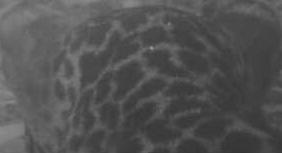

In [3]:
random.seed(14)

folder_path = './demo_images'
images = os.listdir(folder_path)

random_image_name = random.choice(images)
random_image_path = os.path.join(folder_path, random_image_name)
random_image = Image.open(random_image_path)
display(random_image_name[:-4])
display(random_image)

## Demo Modell

In [83]:
class predict_model(modelling.CCV1_Trainer):
    def __init__(self,device):
        self.device = device

class pred_images():
    def __init__(self) -> None:
        self.transformer = pred_images.preprocessing()
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def pred_image(self,mega_range:str,image:PIL,visualize_output:bool=True):
        image_prep = self.transformer(image).to(self.device)
        if mega_range=="high":
            model = self.prep_model("../model_submit/convnext_tiny_1epoch.pth")
            preds = predict_model(self.device).predict(model=model.to(self.device),data_loader=[{"image":image_prep.view(1,3, 224, 224).to(self.device)}])[0]
        elif mega_range=="medium":
            pass
        elif mega_range=="low":
            pass
        else:
            print("possible mega ranges are: 'high','medium','low'")
            raise ValueError
        preds = torch.softmax(torch.from_numpy(preds), dim=1)
        if visualize_output:
            plt.imshow(random_image)
            plt.title(F"{list(Animal)[preds.argmax()].value}: {np.array(preds.max()).round(4)}" )
            plt.show()
        else:
            for x in range(8):
                print(F"{list(Animal)[x]}: {np.array(preds[0][x]).round(4)}")
            return preds

    @staticmethod
    def preprocessing(pretrained_model:str="convnext"):
        model_transformer = CCV1Transformer(
            transforms.Compose([None_Transform()]), "model_specific", pretrained_model
        ).getCompose(True)
        return model_transformer
    
    @staticmethod
    def convnext_tiny_():
        model = models.convnext_tiny(weights=None,)
        model.classifier[2] =nn.Linear(in_features=768, out_features=8, bias=True)
        return model
    
    def prep_model(self,model_path:str):
        model =pred_images.convnext_tiny_()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model.to(self.device)

In [84]:
pred = pred_images()

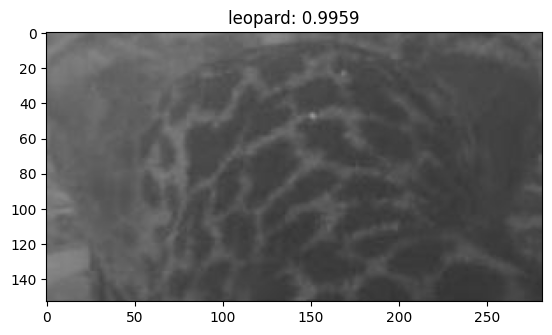

In [85]:
pred.pred_image("high",random_image)

In [86]:
preds = pred.pred_image("high",random_image,visualize_output=False)

antelope_duiker: 0.0001
bird: 0.0
blank: 0.0032
civet_genet: 0.0002
hog: 0.0002
leopard: 0.9959
monkey_prosimian: 0.0001
rodent: 0.0001
